## 305 - Combining METARs and Surface Analysis

[Youtube](https://www.youtube.com/watch?v=EoE9WedTycY)

[Plotting Fronts - Metpy](https://unidata.github.io/MetPy/latest/examples/plots/Plotting_Surface_Analysis.html)

In [1]:
from siphon.catalog import TDSCatalog

In [2]:
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')
ds = cat.datasets[0]
ds.download()

In [3]:
from metpy.io import parse_metar_file

In [4]:
data = parse_metar_file(ds.name)

/tmp/ipykernel_192307/1531027125.py:1: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  data = parse_metar_file(ds.name)


In [5]:
data.columns

Index(['station_id', 'latitude', 'longitude', 'elevation', 'date_time',
       'wind_direction', 'wind_speed', 'wind_gust', 'visibility',
       'current_wx1', 'current_wx2', 'current_wx3', 'low_cloud_type',
       'low_cloud_level', 'medium_cloud_type', 'medium_cloud_level',
       'high_cloud_type', 'high_cloud_level', 'highest_cloud_type',
       'highest_cloud_level', 'cloud_coverage', 'air_temperature',
       'dew_point_temperature', 'altimeter', 'current_wx1_symbol',
       'current_wx2_symbol', 'current_wx3_symbol', 'remarks',
       'air_pressure_at_sea_level', 'eastward_wind', 'northward_wind'],
      dtype='object')

In [6]:
from metpy.io import parse_wpc_surface_bulletin
import urllib.request
from io import BytesIO

In [7]:
url = 'http://www.wpc.ncep.noaa.gov/discussions/codsus'
with urllib.request.urlopen(url) as response:
	content = response.read()
fronts = parse_wpc_surface_bulletin(BytesIO(content))

In [8]:
fronts

,valid,feature,strength,geometry
0,2023-12-28,HIGH,1022,POINT (-125 26)
1,2023-12-28,HIGH,1023,POINT (-71 51)
2,2023-12-28,HIGH,1023,POINT (-139 64)
3,2023-12-28,HIGH,1023,POINT (-93 51)
4,2023-12-28,HIGH,1038,POINT (-108 41)
...,...,...,...,...
102,2023-12-28,STNRY,WK,"LINESTRING (-128 50, -126 48, -125 45, -124 43)"
103,2023-12-28,STNRY,WK,"LINESTRING (-124 43, -124 41, -124 41)"
104,2023-12-28,STNRY,WK,"LINESTRING (-124 40, -124 39)"
105,2023-12-28,TROF,NaN,"LINESTRING (-124 63, -124 62, -124 61)"


In [9]:
from datetime import timedelta, datetime
import metpy.plots as mpplots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from metpy.plots import (ColdFront, OccludedFront, StationaryFront, WarmFront)

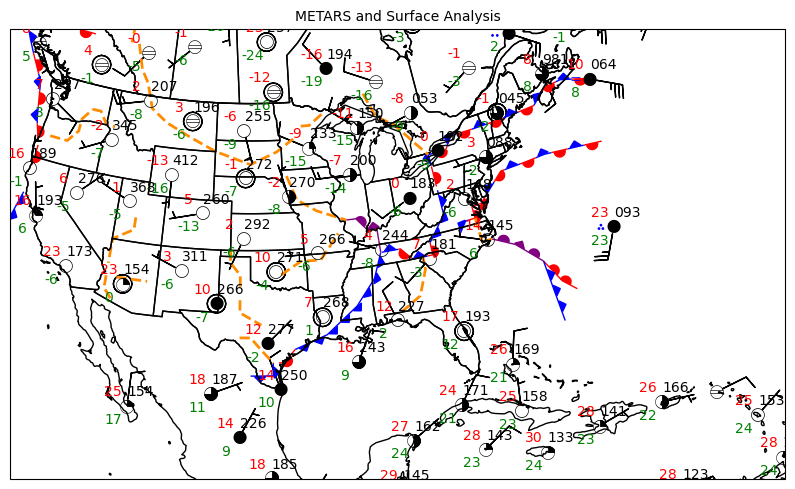

In [10]:
obs = mpplots.PlotObs()
obs.data = data
obs.time = datetime(2023, 12, 28)
obs.time_window = timedelta(minutes = 15)
obs.level = None
obs.fields = ['air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level', 'cloud_coverage', 'current_wx1_symbol']
obs.locations = ['NW', 'SW', 'NE', 'C', 'W']
obs.colors = ['red', 'green', 'black', 'black', 'blue']
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover', 'current_weather']
obs.vector_field = ('eastward_wind', 'northward_wind')
obs.reduce_points = 4


panel = mpplots.MapPanel()
panel.layout = (1, 1, 1)
panel.area = 'us'
panel.projection = 'lcc'
panel.layers = ['coastline' ,'borders', 'states']
panel.title = 'METARS and Surface Analysis'
panel.plots = [obs]

pc = mpplots.PanelContainer()
pc.size = (10, 10)
pc.panels = [panel]

ax = panel.ax
size = 4
complete_style = {'WARM': {'linewidth': 1, 'path_effects': [WarmFront(size=size)]},
                  'COLD': {'linewidth': 1, 'path_effects': [ColdFront(size=size)]},
                  'OCFNT': {'linewidth': 1, 'path_effects': [OccludedFront(size=size)]},
                  'STNRY': {'linewidth': 1, 'path_effects': [StationaryFront(size=size)]},
                  'TROF': {'linewidth': 2, 'linestyle': 'dashed','edgecolor': 'darkorange'}}

# Handle all the boundary types
for field in ('WARM', 'COLD', 'STNRY', 'OCFNT', 'TROF'):
    rows = fronts[fronts.feature == field]
    ax.add_geometries(rows.geometry, crs=ccrs.PlateCarree(), **complete_style[field],
                        facecolor='none')
        
pc.show()